In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    output = torch.tanh(self.input_layer(x))
    for layer in self.hidden_layers:
      output = layer(output)
    theta = self.output_layer(output)
    theta_prime = torch.autograd.grad(theta, x, torch.ones_like(theta),create_graph=True)[0]
    theta_double_prime = torch.autograd.grad(theta_prime, x, torch.ones_like(theta),create_graph=True)[0]
    return theta, theta_prime, theta_double_prime

In [ ]:
## Actual Data
file_path = '/content/bl_convection.txt'
delimiter = '    '
selected_columns = [0, 1, 4, 5]
selected_data = []

with open(file_path, 'r') as file:
    for line_number, line in enumerate(file, 1):
        columns = line.strip().split('    ')
        selected_values = [columns[i] for i in selected_columns]
        selected_data.append(selected_values)
column_names = ['eta', 'f', 'theta', 'theta_prime']
df_selected = pd.DataFrame(selected_data, columns=column_names)

In [ ]:
df_copy  = df_selected
df_copy = df_copy.astype(str)

In [ ]:
def apply(val):
  val_copy = val.split('D')
  return float(val_copy[0])*(10**(float(val_copy[1])))

In [ ]:
df_copy = df_copy.applymap(apply)

In [ ]:
column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
column_1_array = column_arrays[0]
column_2_array = column_arrays[1]
column_3_array = column_arrays[2]
column_4_array = column_arrays[3]
column_1_array = column_1_array[::1000]
column_2_array = column_2_array[::1000]
column_3_array = column_3_array[::1000]
column_4_array = column_4_array[::1000]
eta = torch.tensor(column_1_array, dtype=torch.float32).reshape(1001,1).view(-1, 1)
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(1001,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(1001,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(1001,1).view(-1, 1)
# theta_prime = torch.autograd.grad(theta, eta, torch.ones_like(theta),create_graph=True,retain_graph=True)[0]
# theta_double_prime = torch.autograd.grad(theta_prime, eta, torch.ones_like(theta),create_graph=True)[0]

In [ ]:
## Defining the PDE
def equation_2(theta, theta_x, theta_xx, x, f, Pr):
    return Pr*theta_x*0.5*f + theta_xx

In [ ]:
## PDE training data
x_train1 = eta
x_train1 = x_train1.requires_grad_(True)

In [ ]:
def boundary_conditions_loss1(theta_train, x):
    # Boundary condition at eta=0:
    loss_bc_0 = torch.mean((theta_train[0])**2)
    # Boundary condition at eta=inf:
    loss_bc_inf = torch.mean((theta_train[-1] - 1)**2)
    return loss_bc_0 + loss_bc_inf

In [ ]:
## Initialization of PINN
Pr = torch.tensor([0.5], requires_grad=True)
torch.manual_seed(69)
pinn = PINN(1,40,1,10)
parameters = [
    {'params': pinn.parameters(), 'lr': 0.0001},
    {'params': [Pr], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters)

In [ ]:
## Training Loop
epochs = 5000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  theta_pred, theta_prime_pred, theta_double_prime_pred = pinn(x_train1)

  Actual_loss = (theta-theta_pred).pow(2).mean() + (theta_prime-theta_prime_pred).pow(2).mean() ##+ (theta_double_prime-theta_double_prime_pred).pow(2).mean()

  pde_loss = equation_2(theta, theta_prime, theta_double_prime_pred, x_train1, f, Pr).pow(2).mean()

  boundary_condition_loss = boundary_conditions_loss1(theta, x_train1)

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*boundary_condition_loss + p2*Actual_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 500 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Actual Loss: {Actual_loss.item()}, Prandtl Number: {Pr.item()}")

Epoch 0/5000, Total Loss: 0.617003858089447, pde Loss: 0.0009411813807673752, Boundary Loss: 0.0, Actual Loss: 0.6160627007484436, Prandtl Number: 0.4750000834465027
Epoch 500/5000, Total Loss: 0.0006673437310382724, pde Loss: 0.00016585363482590765, Boundary Loss: 0.0, Actual Loss: 0.0005014900816604495, Prandtl Number: 0.6556669473648071
Epoch 1000/5000, Total Loss: 0.0003620102652348578, pde Loss: 0.00013547179696615785, Boundary Loss: 0.0, Actual Loss: 0.00022653845371678472, Prandtl Number: 0.688346266746521
Epoch 1500/5000, Total Loss: 0.00020320495241321623, pde Loss: 6.938819569768384e-05, Boundary Loss: 0.0, Actual Loss: 0.00013381676399149, Prandtl Number: 0.6927226185798645
Epoch 2000/5000, Total Loss: 5.663074261974543e-05, pde Loss: 2.734536974458024e-05, Boundary Loss: 0.0, Actual Loss: 2.928537105617579e-05, Prandtl Number: 0.6978355646133423
Epoch 2500/5000, Total Loss: 3.393969382159412e-05, pde Loss: 1.7527992895338684e-05, Boundary Loss: 0.0, Actual Loss: 1.641170092

In [ ]:
print(Pr.item())

0.69819575548172


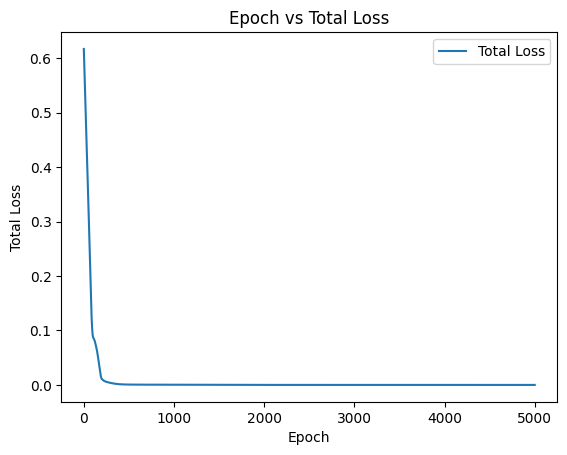

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

In [ ]:
column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
column_1_array = column_arrays[0]
column_2_array = column_arrays[1]
column_3_array = column_arrays[2]
column_4_array = column_arrays[3]
column_1_array = column_1_array[::10000]
column_2_array = column_2_array[::10000]
column_3_array = column_3_array[::10000]
column_4_array = column_4_array[::10000]
eta = torch.tensor(column_1_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(101,1).view(-1, 1)

In [ ]:
x_train2 = eta
x_train2 = x_train2.requires_grad_(True)

In [ ]:
## Initialization of PINN
Pr = torch.tensor([0.5], requires_grad=True)
torch.manual_seed(69)
pinn2 = PINN(1,40,1,10)
parameters2 = [
    {'params': pinn2.parameters(), 'lr': 0.0001},
    {'params': [Pr], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters2)

In [ ]:
## Training Loop
epochs = 5000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  theta_pred, theta_prime_pred, theta_double_prime_pred = pinn2(x_train2)

  Actual_loss = (theta-theta_pred).pow(2).mean() + (theta_prime-theta_prime_pred).pow(2).mean() ##+ (theta_double_prime-theta_double_prime_pred).pow(2).mean()

  pde_loss = equation_2(theta, theta_prime, theta_double_prime_pred, x_train2, f, Pr).pow(2).mean()

  boundary_condition_loss = boundary_conditions_loss1(theta, x_train2)

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*boundary_condition_loss + p2*Actual_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 500 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Actual Loss: {Actual_loss.item()}, Prandtl Number: {Pr.item()}")

Epoch 0/5000, Total Loss: 0.6156319975852966, pde Loss: 0.0009327991283498704, Boundary Loss: 0.0, Actual Loss: 0.6146991848945618, Prandtl Number: 0.4750000834465027
Epoch 500/5000, Total Loss: 0.0006745830178260803, pde Loss: 0.00017821439541876316, Boundary Loss: 0.0, Actual Loss: 0.0004963686224073172, Prandtl Number: 0.6574617624282837
Epoch 1000/5000, Total Loss: 0.0003665823896881193, pde Loss: 0.000137275448651053, Boundary Loss: 0.0, Actual Loss: 0.00022930694103706628, Prandtl Number: 0.6878194212913513
Epoch 1500/5000, Total Loss: 0.00019313357188366354, pde Loss: 6.492489774245769e-05, Boundary Loss: 0.0, Actual Loss: 0.00012820867414120585, Prandtl Number: 0.692782461643219
Epoch 2000/5000, Total Loss: 4.9238493375014514e-05, pde Loss: 2.5726018066052347e-05, Boundary Loss: 0.0, Actual Loss: 2.3512475308962166e-05, Prandtl Number: 0.6980223059654236
Epoch 2500/5000, Total Loss: 3.470398223726079e-05, pde Loss: 1.77625406649895e-05, Boundary Loss: 0.0, Actual Loss: 1.694144

In [ ]:
print(Pr.item())

0.6982096433639526


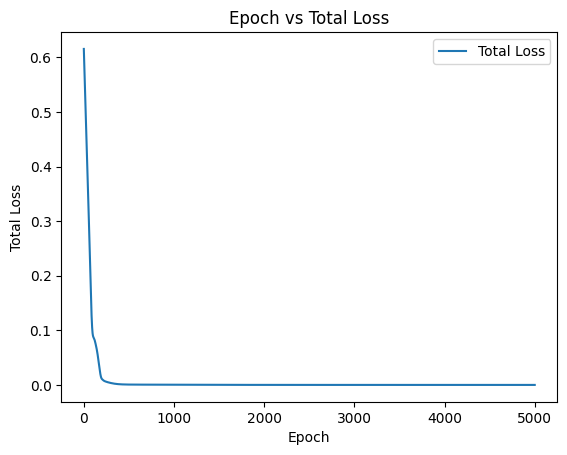

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

In [ ]:
column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
column_1_array = column_arrays[0]
column_2_array = column_arrays[1]
column_3_array = column_arrays[2]
column_4_array = column_arrays[3]
column_1_array = column_1_array[::100000]
column_2_array = column_2_array[::100000]
column_3_array = column_3_array[::100000]
column_4_array = column_4_array[::100000]
eta = torch.tensor(column_1_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(11,1).view(-1, 1)

In [ ]:
x_train3 = eta
x_train3 = x_train3.requires_grad_(True)

In [ ]:
## Initialization of PINN
Pr = torch.tensor([0.5], requires_grad=True)
torch.manual_seed(69)
pinn3 = PINN(1,40,1,10)
parameters3 = [
    {'params': pinn3.parameters(), 'lr': 0.0001},
    {'params': [Pr], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters3)

In [ ]:
## Training Loop
epochs = 5000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  theta_pred, theta_prime_pred, theta_double_prime_pred = pinn3(x_train3)

  Actual_loss = (theta-theta_pred).pow(2).mean() + (theta_prime-theta_prime_pred).pow(2).mean() ##+ (theta_double_prime-theta_double_prime_pred).pow(2).mean()

  pde_loss = equation_2(theta, theta_prime, theta_double_prime_pred, x_train3, f, Pr).pow(2).mean()

  boundary_condition_loss = boundary_conditions_loss1(theta, x_train3)

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*boundary_condition_loss + p2*Actual_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 500 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Actual Loss: {Actual_loss.item()}, Prandtl Number: {Pr.item()}")

Epoch 0/5000, Total Loss: 0.6035098433494568, pde Loss: 0.0008564938325434923, Boundary Loss: 0.0, Actual Loss: 0.6026533246040344, Prandtl Number: 0.4750000834465027
Epoch 500/5000, Total Loss: 0.0006941299070604146, pde Loss: 0.00016004806093405932, Boundary Loss: 0.0, Actual Loss: 0.00053408183157444, Prandtl Number: 0.6566222906112671
Epoch 1000/5000, Total Loss: 0.0003174660378135741, pde Loss: 8.149932546075433e-05, Boundary Loss: 0.0, Actual Loss: 0.0002359666978009045, Prandtl Number: 0.6887845993041992
Epoch 1500/5000, Total Loss: 0.00017012232274282724, pde Loss: 5.343713201000355e-05, Boundary Loss: 0.0, Actual Loss: 0.00011668518709484488, Prandtl Number: 0.6955053806304932
Epoch 2000/5000, Total Loss: 5.302062345435843e-05, pde Loss: 2.6499579689698294e-05, Boundary Loss: 0.0, Actual Loss: 2.6521043764660135e-05, Prandtl Number: 0.6961843371391296
Epoch 2500/5000, Total Loss: 4.1495553887216374e-05, pde Loss: 1.798413723008707e-05, Boundary Loss: 0.0, Actual Loss: 2.351141

In [ ]:
print(Pr.item())

0.6927605271339417


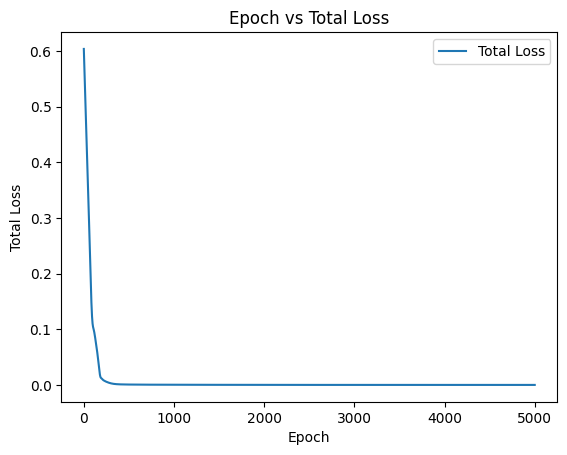

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

In [ ]:
gaussian_noise = numpy.random.normal(0, 0.001, column_1_array.shape)
column_2_array = column_2_array + gaussian_noise
column_3_array = column_3_array + gaussian_noise
column_4_array = column_4_array + gaussian_noise
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(11,1).view(-1, 1)

In [ ]:
## Initialization of PINN
Pr = torch.tensor([0.5], requires_grad=True)
torch.manual_seed(69)
pinn4 = PINN(1,40,1,10)
parameters4 = [
    {'params': pinn4.parameters(), 'lr': 0.0001},
    {'params': [Pr], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters4)

In [ ]:
## Training Loop
epochs = 10000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  theta_pred, theta_prime_pred, theta_double_prime_pred = pinn4(x_train3)

  Actual_loss = (theta-theta_pred).pow(2).mean() + (theta_prime-theta_prime_pred).pow(2).mean() ##+ (theta_double_prime-theta_double_prime_pred).pow(2).mean()

  pde_loss = equation_2(theta, theta_prime, theta_double_prime_pred, x_train3, f, Pr).pow(2).mean()

  boundary_condition_loss = boundary_conditions_loss1(theta, x_train3)

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*boundary_condition_loss + p2*Actual_loss - 11*(3*0.001)**2

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 1000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Actual Loss: {Actual_loss.item()}, Prandtl Number: {Pr.item()}")

Epoch 0/10000, Total Loss: 0.6037096381187439, pde Loss: 0.0008543532458133996, Boundary Loss: 8.891698826118954e-07, Actual Loss: 0.6029533743858337, Prandtl Number: 0.4750000834465027
Epoch 1000/10000, Total Loss: 0.0002186140336561948, pde Loss: 8.311879355460405e-05, Boundary Loss: 8.891698826118954e-07, Actual Loss: 0.00023360605700872838, Prandtl Number: 0.6872624158859253
Epoch 2000/10000, Total Loss: -4.529264697339386e-05, pde Loss: 2.658818084455561e-05, Boundary Loss: 8.891698826118954e-07, Actual Loss: 2.6230000003124587e-05, Prandtl Number: 0.6946601867675781
Epoch 3000/10000, Total Loss: -6.401418067980558e-05, pde Loss: 1.422269269824028e-05, Boundary Loss: 8.891698826118954e-07, Actual Loss: 1.987395080504939e-05, Prandtl Number: 0.6904710531234741
Epoch 4000/10000, Total Loss: -7.776842539897189e-05, pde Loss: 8.267962584795896e-06, Boundary Loss: 8.891698826118954e-07, Actual Loss: 1.2074437108822167e-05, Prandtl Number: 0.690041184425354
Epoch 5000/10000, Total Loss:

In [ ]:
print(Pr.item())

0.6977475881576538


In [ ]:
gaussian_noise = numpy.random.normal(0, 0.01, column_1_array.shape)
column_2_array = column_2_array + gaussian_noise
column_3_array = column_3_array + gaussian_noise
column_4_array = column_4_array + gaussian_noise
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(11,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(11,1).view(-1, 1)

In [ ]:
## Initialization of PINN
Pr = torch.tensor([0.5], requires_grad=True)
torch.manual_seed(69)
pinn5 = PINN(1,40,1,10)
parameters5 = [
    {'params': pinn5.parameters(), 'lr': 0.0001},
    {'params': [Pr], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters5)

In [ ]:
## Training Loop
epochs = 10000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  theta_pred, theta_prime_pred, theta_double_prime_pred = pinn5(x_train3)

  Actual_loss = (theta-theta_pred).pow(2).mean() + (theta_prime-theta_prime_pred).pow(2).mean() ##+ (theta_double_prime-theta_double_prime_pred).pow(2).mean()

  pde_loss = equation_2(theta, theta_prime, theta_double_prime_pred, x_train3, f, Pr).pow(2).mean()

  boundary_condition_loss = boundary_conditions_loss1(theta, x_train3)

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*boundary_condition_loss + p2*Actual_loss - 11*(3*0.01)**2

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 1000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Actual Loss: {Actual_loss.item()}, Prandtl Number: {Pr.item()}")

Epoch 0/10000, Total Loss: 0.5925911068916321, pde Loss: 0.0008653145632706583, Boundary Loss: 0.0002682073100004345, Actual Loss: 0.6013575792312622, Prandtl Number: 0.4750000834465027
Epoch 1000/10000, Total Loss: -0.009178281761705875, pde Loss: 0.00015152849664445966, Boundary Loss: 0.0002682073100004345, Actual Loss: 0.0003019820724148303, Prandtl Number: 0.6483398675918579
Epoch 2000/10000, Total Loss: -0.009399435482919216, pde Loss: 0.00010723008745117113, Boundary Loss: 0.0002682073100004345, Actual Loss: 0.00012512734974734485, Prandtl Number: 0.6536150574684143
Epoch 3000/10000, Total Loss: -0.009438005276024342, pde Loss: 8.504260767949745e-05, Boundary Loss: 0.0002682073100004345, Actual Loss: 0.00010874452709686011, Prandtl Number: 0.6481258273124695
Epoch 4000/10000, Total Loss: -0.009464967995882034, pde Loss: 7.404158532153815e-05, Boundary Loss: 0.0002682073100004345, Actual Loss: 9.278316429117694e-05, Prandtl Number: 0.6479671001434326
Epoch 5000/10000, Total Loss: 

In [ ]:
print(Pr.item())

0.6568371057510376


In [ ]:
column_arrays = [df_copy.iloc[:, i].to_numpy() for i in range(df_selected.shape[1])]
column_1_array = column_arrays[0]
column_2_array = column_arrays[1]
column_3_array = column_arrays[2]
column_4_array = column_arrays[3]
column_1_array = column_1_array[::10000]
column_2_array = column_2_array[::10000]
column_3_array = column_3_array[::10000]
column_4_array = column_4_array[::10000]
eta = torch.tensor(column_1_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(101,1).view(-1, 1)

In [ ]:
gaussian_noise = numpy.random.normal(0, 0.01, column_1_array.shape)
column_2_array = column_2_array + gaussian_noise
column_3_array = column_3_array + gaussian_noise
column_4_array = column_4_array + gaussian_noise
f = torch.tensor(column_2_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
theta = torch.tensor(column_3_array, dtype=torch.float32).reshape(101,1).view(-1, 1)
theta_prime = torch.tensor(column_4_array, dtype=torch.float32).reshape(101,1).view(-1, 1)

In [ ]:
## Initialization of PINN
Pr = torch.tensor([0.5], requires_grad=True)
torch.manual_seed(69)
pinn6 = PINN(1,40,1,10)
parameters6 = [
    {'params': pinn6.parameters(), 'lr': 0.0001},
    {'params': [Pr], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters6)

In [ ]:
## Training Loop
epochs = 10000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  theta_pred, theta_prime_pred, theta_double_prime_pred = pinn6(x_train2)

  Actual_loss = (theta-theta_pred).pow(2).mean() + (theta_prime-theta_prime_pred).pow(2).mean() ##+ (theta_double_prime-theta_double_prime_pred).pow(2).mean()

  pde_loss = equation_2(theta, theta_prime, theta_double_prime_pred, x_train2, f, Pr).pow(2).mean()

  boundary_condition_loss = boundary_conditions_loss1(theta, x_train2)

  p1 = 1
  p2 = 1
  total_loss = pde_loss + p1*boundary_condition_loss + p2*Actual_loss - 101*(3*0.01)**2

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 1000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Actual Loss: {Actual_loss.item()}, Prandtl Number: {Pr.item()}")

Epoch 0/10000, Total Loss: 0.5253406167030334, pde Loss: 0.0010669986950233579, Boundary Loss: 0.00014052468759473413, Actual Loss: 0.6150330901145935, Prandtl Number: 0.4750000536441803
Epoch 1000/10000, Total Loss: -0.0899805948138237, pde Loss: 0.00031452119583263993, Boundary Loss: 0.00014052468759473413, Actual Loss: 0.0004643567372113466, Prandtl Number: 0.6012060642242432
Epoch 2000/10000, Total Loss: -0.09035024791955948, pde Loss: 0.0001998414663830772, Boundary Loss: 0.00014052468759473413, Actual Loss: 0.00020938541274517775, Prandtl Number: 0.6107372045516968
Epoch 3000/10000, Total Loss: -0.09036625921726227, pde Loss: 0.00018811725021805614, Boundary Loss: 0.00014052468759473413, Actual Loss: 0.00020509521709755063, Prandtl Number: 0.6088052988052368
Epoch 4000/10000, Total Loss: -0.0903749018907547, pde Loss: 0.0001838325260905549, Boundary Loss: 0.00014052468759473413, Actual Loss: 0.00020074003259651363, Prandtl Number: 0.6095564365386963
Epoch 5000/10000, Total Loss: 

In [ ]:
print(Pr.item())

0.6110538840293884
